In [1]:
import torch
from pinder.core import get_index, PinderSystem
from pinder.core import PinderLoader
from pinder.core.loader import filters
from pinder.core.loader import structure
from pinder.core.index.system import PinderSystem
from pinder.core import get_pinder_location
import re
import pandas as pd
import csv
import os
import random
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from transformers import AutoModel, AutoTokenizer
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import rel_entr

TAX_LEVEL="species"

HOME="/scicore/home/schwede/pudziu0000/"
PINDER_BASE_DIR="/scicore/home/schwede/durair0000/.local/share/"
UNIPROT_IDS_PATH=f"{HOME}/projects/gLM/data/PINDER/uniprot_ids_1024_512.lst"
UNIPROT_LINEAGES_PATH=f"{HOME}/projects/gLM/data/PINDER/uniprot_lineages_annotations_1024_512.tsv"
SPLITS_DIR=f"{HOME}/projects/gLM/data/PINDER/eubacteria_5_1024_512_{TAX_LEVEL}/"
SEED=1024

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModel.from_pretrained(f"{HOME}/projects/gLM/gLM2_650M", torch_dtype=torch.bfloat16, trust_remote_code=True).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(f"{HOME}/projects/gLM/gLM2_650M", trust_remote_code=True)

random.seed(SEED)

def select_ids(max_length=1024, max_length_per_monomer=400):
    base_filters = [
        filters.FilterByMissingHolo(),
        filters.FilterSubByContacts(min_contacts=5, radius=10.0, calpha_only=True),
        filters.FilterDetachedHolo(radius=12, max_components=2),
    ]
    sub_filters = [
        filters.FilterSubByAtomTypes(min_atom_types=4),
        filters.FilterByHoloOverlap(min_overlap=5),
        filters.FilterByHoloSeqIdentity(min_sequence_identity=0.8),
        filters.FilterSubRmsds(rmsd_cutoff=7.5),
        filters.FilterDetachedSub(radius=12, max_components=2),
    ]
    split_pinder_ids = {}
    split_uniprot_ids = {}
    train_index = None
    for split in ["train", "val", "test"]:
        loader = PinderLoader(
            split=split,
            monomer_priority="holo",
            base_filters=base_filters,
            sub_filters=sub_filters,
        )
            
        index = loader.index.merge(loader.metadata, on="id", how="left")
        index["length"] = index["length1"] + index["length2"]
        index["resolution"] = index["resolution"].astype("float32")
        index = index[
            (index["length"] + 2 <= max_length)
            & (index["length1"] <= max_length_per_monomer)
            & (index["length2"] <= max_length_per_monomer)
            & (index["label"] == "BIO")
        ]
        if(split == "train"): train_index = index
        pinder_ids = list(index["id"])
        uniprot_ids = set(list(index["uniprot_R"]) + list(index["uniprot_L"]))
        split_pinder_ids[split] = pinder_ids
        split_uniprot_ids[split] = uniprot_ids
    return split_pinder_ids, split_uniprot_ids, train_index

def reduce_train_redundancy(ids, index, max_per_cluster=5):
    # ids - list of ids of the training set
    # index - index of the training set
    ids = list(
        set(
            index.sort_values(
                ["resolution", "id"],
                ascending=[True, True],
            )
            .groupby("cluster_id", observed=False)
            .head(max_per_cluster)["id"]
        )
    )
    return ids

def get_positives_df(split, pinder_ids, pinder_tax_annot):
    positives = []
    for id_ in eubacteria_pinder_ids[split]:
        record = {
            "pinder_id": id_,
            "pinder_id_R": id_.split("--")[0], 
            "pinder_id_L": id_.split("--")[1], 
            f"{TAX_LEVEL}_R": pinder_tax_annot[id_][0],
            f"{TAX_LEVEL}_L": pinder_tax_annot[id_][1]}
        positives.append(record)
    return pd.DataFrame.from_dict(positives)

def make_random_pairs(L, pdb_L, chain_uniprot_L, uniprot_L, 
                      pdb_R, uniprot_R,
                      interacting_partners, GO, max_num_attempts):
    invalidity_flags = []
    # Shuffle until no same PDB pairs
    for attempt in range(max_num_attempts):  # Limit reattempts
        L_info = list(zip(L, pdb_L, chain_uniprot_L, uniprot_L))
        if(len(L_info) == 0): return (None, None, None, None, None)
        random.Random(SEED).shuffle(L_info)
        L, pdb_L, chain_uniprot_L, uniprot_L = zip(*L_info)
        
        # If UniProt IDs of the new pair are known to contain interacting sequences, retry
        if any(uL in interacting_partners[uR] for uR, uL in zip(uniprot_R, uniprot_L)):
            if(attempt != max_num_attempts-1):
                continue
            else:
                invalidity_flags.append("interacting")
                
        # If UniProt IDs of the new pair have overlapping Molecular Function GOs, retry
        if any(bool(set(GO[uR]) & set(GO[uL])) for uR, uL in zip(uniprot_R, uniprot_L)):
            if(attempt != max_num_attempts-1):
                continue
            else:
                invalidity_flags.append("GO")

        # If PDB IDs of all pairs are non-matching, call it a success
        if all(pR != pL for pR, pL in zip(pdb_R, pdb_L)): break

    return L, pdb_L, chain_uniprot_L, uniprot_L, invalidity_flags


def remove_false_negatives(R, L, uniprot_R, uniprot_L, interacting_partners, 
                           GO, invalidity_flags, orig_pinder_ids):
    # If there are invalid pairings, execute removals
    if(invalidity_flags):
        to_remove = set()
        for i, (uR, uL) in enumerate(zip(uniprot_R, uniprot_L)):
            if "interacting" in invalidity_flags and uL in interacting_partners[uR]: to_remove.add(i)
            if "GO" in invalidity_flags and bool(set(GO[uR]) & set(GO[uL])): to_remove.add(i)
        
        valid_indices_R = set(range(len(R)))-to_remove
        valid_indices_L = set(range(len(L)))-to_remove
        R = [R[i] for i in valid_indices_R]
        L = [L[i] for i in valid_indices_L]

    # Forming new pinder_ids
    paired = zip(R, L)
    paired = ["--".join(pair) for pair in paired]
    
    # If new pinder_id is present in the original set, remove that record
    paired = [item for item in paired if item not in orig_pinder_ids]

    return paired

def make_negative_pairs(dfR, dfL, interacting_partners, GO, seed=SEED, max_num_attempts=5, tax_level="phylum"):    
    # Separate ids
    
    dfR[['R', 'L']] = dfR['pinder_id'].str.split('--', expand=True)
    dfR[['pdb_R', 'chain_uniprot_R']] = dfR['R'].str.split('__', expand=True)
    dfR[['chain_R', 'uniprot_R']] = dfR['chain_uniprot_R'].str.split('_', expand=True)
    dfR[['pdb_L', 'chain_uniprot_L']] = dfR['L'].str.split('__', expand=True)
    dfR[['chain_L', 'uniprot_L']] = dfR['chain_uniprot_L'].str.split('_', expand=True)

    dfL[['R', 'L']] = dfL['pinder_id'].str.split('--', expand=True)
    dfL[['pdb_R', 'chain_uniprot_R']] = dfL['R'].str.split('__', expand=True)
    dfL[['chain_R', 'uniprot_R']] = dfL['chain_uniprot_R'].str.split('_', expand=True)
    dfL[['pdb_L', 'chain_uniprot_L']] = dfL['L'].str.split('__', expand=True)
    dfL[['chain_L', 'uniprot_L']] = dfL['chain_uniprot_L'].str.split('_', expand=True)
    
    # Group by tax_level
    negative_ids = []
    negative_phyla = []
    orig_pinder_ids = set(dfR['pinder_id'])
    
    for tax_level_el, group in dfR.groupby(f'{tax_level}_R'):
        R = group['R'].tolist()
        pdb_R = group['pdb_R'].tolist()
        uniprot_R = group['uniprot_R'].tolist()

        group_L = dfL[dfL[f'{tax_level}_L'] == tax_level_el]
        L = group_L['L'].tolist()
        pdb_L = group_L['pdb_L'].tolist()
        chain_uniprot_L = group_L['chain_uniprot_L'].tolist()
        uniprot_L = group_L['uniprot_L'].tolist()

        L, pdb_L, chain_uniprot_L, uniprot_L, invalidity_flags = make_random_pairs(
            L, pdb_L, chain_uniprot_L, uniprot_L, pdb_R, uniprot_R, 
            interacting_partners, GO, max_num_attempts
        )
        # If there are no pairs to form
        if(not L): continue
        
        # If there are invalid pairings, execute removals and get pairs
        paired = remove_false_negatives(R, L, uniprot_R, uniprot_L, 
            interacting_partners, GO, invalidity_flags, orig_pinder_ids
        )

        negative_ids.extend(paired)
        negative_phyla.extend([tax_level_el]*len(paired))

    negative_records = list(zip(negative_ids, negative_phyla, negative_phyla))
    negative_df = pd.DataFrame(
        negative_records, 
        columns=['pinder_id', f'{tax_level}_R', f'{tax_level}_L']
    ).sample(frac=1, random_state=seed).reset_index(drop=True)
    
    negative_df[['pinder_id_R', 'pinder_id_L']] = negative_df['pinder_id'].str.split('--', expand=True)
    
    return negative_df

def rename_columns(df, to_drop=None, tax_level="phylum"):
    df.rename(columns={
        "pinder_id_R": "protein1",
        "pinder_id_L": "protein2",
        f"{tax_level}_R": f"{tax_level}1",
        f"{tax_level}_L": f"{tax_level}2"
    }, inplace=True)
    if(to_drop): df.drop([to_drop], axis=1, inplace=True)
    return df

def get_sequences(df):
    ids = {"R": set(), "L": set()}
    
    for i, j in df.iterrows():
        ids["R"].add(df["pinder_id_R"][i])
        ids["L"].add(df["pinder_id_L"][i])
        
    seqs = {}
    for k in ids:
        for id_ in ids[k]:
            struct = structure.Structure(f"{PINDER_BASE_DIR}/pinder/2024-02/pdbs/{id_}-{k}.pdb", pinder_id=id_)
            seqs[id_] = struct.sequence
    return seqs

def plot_distributions(dist1, dist2, title, split):
    matplotlib.rcParams['figure.dpi'] = 300
    plt.figure(figsize=(10, 5))

    hist1, _ = np.histogram(dist1, density=True)
    hist2, _ = np.histogram(dist2, density=True)
    
    plt.hist(dist1, color='red', alpha=0.5, label='positive')
    plt.hist(dist2, color='blue', alpha=0.5, label='negative')
    plt.xlabel('distance')
    plt.ylabel('frequency')
    plt.title(title)
    plt.legend()
    
    plt.savefig(f"{HOME}/projects/gLM/data/PINDER/{split}.png", dpi=200)
    plt.clf()
    
    return hist1, hist2

def compute_KL_divergence(hist1, hist2):
    # Clip to avoid division by zero and ensure valid inputs
    epsilon = 1e-10
    p1 = np.clip(hist1, epsilon, None)
    p2 = np.clip(hist2, epsilon, None)
    
    # Normalize histograms to make them proper probability distributions
    p1 /= p1.sum()
    p2 /= p2.sum()
    
    kl_12 = np.sum(rel_entr(p1, p2))
    kl_21 = np.sum(rel_entr(p2, p1))
    
    return kl_12, kl_21

def generate_embeddings(df, seq_df, model, tokenizer, num_samples=5, emb_dim=1280):
    embs_R = torch.empty((1, num_samples, emb_dim), dtype=torch.float64)
    embs_L = torch.empty((1, num_samples, emb_dim), dtype=torch.float64)

    df = df.reset_index()
    for i, record in df[:num_samples].iterrows():
        enc_R = tokenizer([seq_df[record['pinder_id_R']]], return_tensors='pt').to(DEVICE)
        enc_L = tokenizer([seq_df[record['pinder_id_L']]], return_tensors='pt').to(DEVICE)
        
        with torch.no_grad():
            embs_R[0][i] = model(enc_R.input_ids, output_hidden_states=True).last_hidden_state.mean(dim=1)
            embs_L[0][i] = model(enc_L.input_ids, output_hidden_states=True).last_hidden_state.mean(dim=1)
            
    return torch.squeeze(embs_R), torch.squeeze(embs_L)

def make_split_fasta(split):
    df = pd.read_csv(f"{SPLITS_DIR}/{split}.txt", sep="\t")

    fasta = []
    # Reducing duplicates
    ids = {"R": set(), "L": set()}
    for i, j in df.iterrows():
        idR = df["protein1"][i]
        idL = df["protein2"][i]
        ids["R"].add(idR)
        ids["L"].add(idL)

    for k in ids:
        for id_ in ids[k]:
            struct = structure.Structure(f"{PINDER_BASE_DIR}/pinder/2024-02/pdbs/{id_}-{k}.pdb", pinder_id=id_)
            fasta.append(SeqRecord(Seq(struct.sequence), id=id_, description=""))
    
    with open(f"{SPLITS_DIR}/{split}.fasta", "w") as output_handle:
        SeqIO.write(fasta, output_handle, "fasta-2line")
    

In [2]:
os.environ["PINDER_BASE_DIR"] = PINDER_BASE_DIR
get_pinder_location()

PosixPath('/scicore/home/schwede/durair0000/.local/share/pinder/2024-02')

In [3]:
pinder_ids, uniprot_ids, train_index = select_ids(max_length_per_monomer=512)

In [4]:
# Checking number of elements in each split
print(len(pinder_ids['train']),
      len(pinder_ids['val']),
      len(pinder_ids['test'])
)

print(len(uniprot_ids['train']),
      len(uniprot_ids['val']),
      len(uniprot_ids['test'])
)

675729 1799 1767
20907 1937 1906


In [5]:
# Selecting that that both defined UniProt IDs
pinder_ids['train'] = [row for row in pinder_ids['train'] if not re.search(r'UNDEFINED', row, re.IGNORECASE)]
pinder_ids['val'] = [row for row in pinder_ids['val'] if not re.search(r'UNDEFINED', row, re.IGNORECASE)]
pinder_ids['test'] = [row for row in pinder_ids['test'] if not re.search(r'UNDEFINED', row, re.IGNORECASE)]

uniprot_ids['train'].remove("UNDEFINED")
uniprot_ids['val'].remove("UNDEFINED")
uniprot_ids['test'].remove("UNDEFINED")

In [6]:
# Checking number of elements in each split after removal of "UNDEFINED"
print(len(pinder_ids['train']),
      len(pinder_ids['val']),
      len(pinder_ids['test'])
)

print(len(uniprot_ids['train']),
      len(uniprot_ids['val']),
      len(uniprot_ids['test'])
)

617197 1748 1688
20906 1936 1905


In [7]:
# Save UniProt IDs to a TXT file for "ID mapping"
with open(UNIPROT_IDS_PATH, 'w') as f:
    for split in ["train", "val", "test"]:
        for line in uniprot_ids[split]:
            f.write(f"{line}\n")

In [8]:
# Manually run the ID mapping on the UniProt

In [9]:
# Determine, which UniProt IDs are belonging to eubacteria with labelled tax_level
lineages = pd.read_csv(UNIPROT_LINEAGES_PATH, sep='\t')

eubacteria_phyla = {}
eubacteria_annotated_interactions = {}
eubacteria_GO = {}

for index, row in lineages.iterrows():
    if isinstance(row['Taxonomic lineage (Ids)'], str) and "2 (superkingdom)" in row['Taxonomic lineage (Ids)']: 
        match = re.search(r'(\d+) \(%s\)' % TAX_LEVEL, row['Taxonomic lineage (Ids)'])
        if match:
            tax_level_tax_id = match.group(1)
            eubacteria_phyla[row['From']] = tax_level_tax_id
            
            # Retrieving UniProt IDs of the known interacting partners
            if(not pd.isna(row['Interacts with'])):
                eubacteria_annotated_interactions[row['From']] = [item.split('-')[0] for item in row['Interacts with'].split('; ')]
            else:
                eubacteria_annotated_interactions[row['From']] = []
            
            # Retrieving GO 
            if(not pd.isna(row['Gene Ontology (molecular function)'])):
                eubacteria_GO[row['From']] = re.findall(r"GO:\d+", row['Gene Ontology (molecular function)'])
            else:
                eubacteria_GO[row['From']] = []

In [10]:
# Determine, which PINDER IDs contain both bacterial proteins
eubacteria_pinder_ids = {'train': [], 'val': [], 'test': []}
eubacteria_pinder_phyla = {}

for split in ["train", "val", "test"]:
    for id in pinder_ids[split]:
        uniprot1 = id.split("--")[0].split("_")[-1]
        uniprot2 = id.split("--")[1].split("_")[-1]
        if(uniprot1 in eubacteria_phyla.keys() and uniprot2 in eubacteria_phyla.keys()):
            eubacteria_pinder_ids[split].append(id)
            eubacteria_pinder_phyla[id] = [eubacteria_phyla[uniprot1], eubacteria_phyla[uniprot2]]

In [11]:
print(len(eubacteria_pinder_ids['train']),
      len(eubacteria_pinder_ids['val']),
      len(eubacteria_pinder_ids['test'])
)

62180 680 645


In [ ]:
positives = {}
negatives = {}
pos_seq = {}
neg_seq = {}
pos_embs_R = {}
pos_embs_L = {}
neg_embs_R = {}
neg_embs_L = {}
pos_dists = {}
neg_dists = {}
hist_pos = {}
hist_neg = {}

for split in ["train", "val", "test"]:
    print("Getting positives")
    positives[split] = get_positives_df(split, eubacteria_pinder_ids, eubacteria_pinder_phyla)
    
    print("Getting positive sequences")
    pos_seq[split] = get_sequences(positives[split])
    
    print("Removing homodimers")
    homodimer_idx = []
    for i, row in positives[split].iterrows():
        # Check for homodimers
        if(pos_seq[split][row["pinder_id_R"]] == pos_seq[split][row["pinder_id_L"]]):
            homodimer_idx.append(i)

    print(f"There are {len(homodimer_idx)} homodimers out of {len(positives[split])} positives")
    positives[split] = positives[split].drop(homodimer_idx)

    print("Getting negatives")
    negatives = make_negative_pairs(positives[split], 
        positives["train"], eubacteria_annotated_interactions, 
        eubacteria_GO, tax_level=TAX_LEVEL
    )

    # Get sequences of the negative complexes
    print("Getting negative sequences")
    neg_seq[split] = get_sequences(negatives[split])

    # Generate embeddings
    print("Generating embeddings")
    pos_embs_R[split], pos_embs_L[split] = generate_embeddings(
        positives[split], pos_seq[split], model, tokenizer, 
        num_samples=len(positives[split]), emb_dim=1280
    )
    neg_embs_R[split], neg_embs_L[split] = generate_embeddings(
        negatives[split], neg_seq[split], model, tokenizer, 
        num_samples=len(negatives[split]), emb_dim=1280
    )
    
    # Compute distances
    print("Computing distances")
    pos_dists[split] = torch.cdist(
        pos_embs_R[split], 
        pos_embs_L[split]
    ).diag()
    neg_dists[split] = torch.cdist(
        neg_embs_R[split], 
        neg_embs_L[split]
    ).diag()

    # Plot
    hist_pos[split], hist_neg[split] = plot_distributions(
        pos_dists[split], neg_dists[split], 
        f"Distance distribution of {split} subset"
    )

    # Compute KL divergence
    print(split, compute_KL_divergence(hist_pos[split], hist_neg[split]))
    
    """
    # Preparations to save
    
    split_positives = split_positives[["pinder_id_R", "pinder_id_L", f"{TAX_LEVEL}_R", f"{TAX_LEVEL}_L"]]

    split_positives = rename_columns(split_positives, tax_level=TAX_LEVEL)
    split_negatives = rename_columns(split_negatives, to_drop="pinder_id", tax_level=TAX_LEVEL)
    """


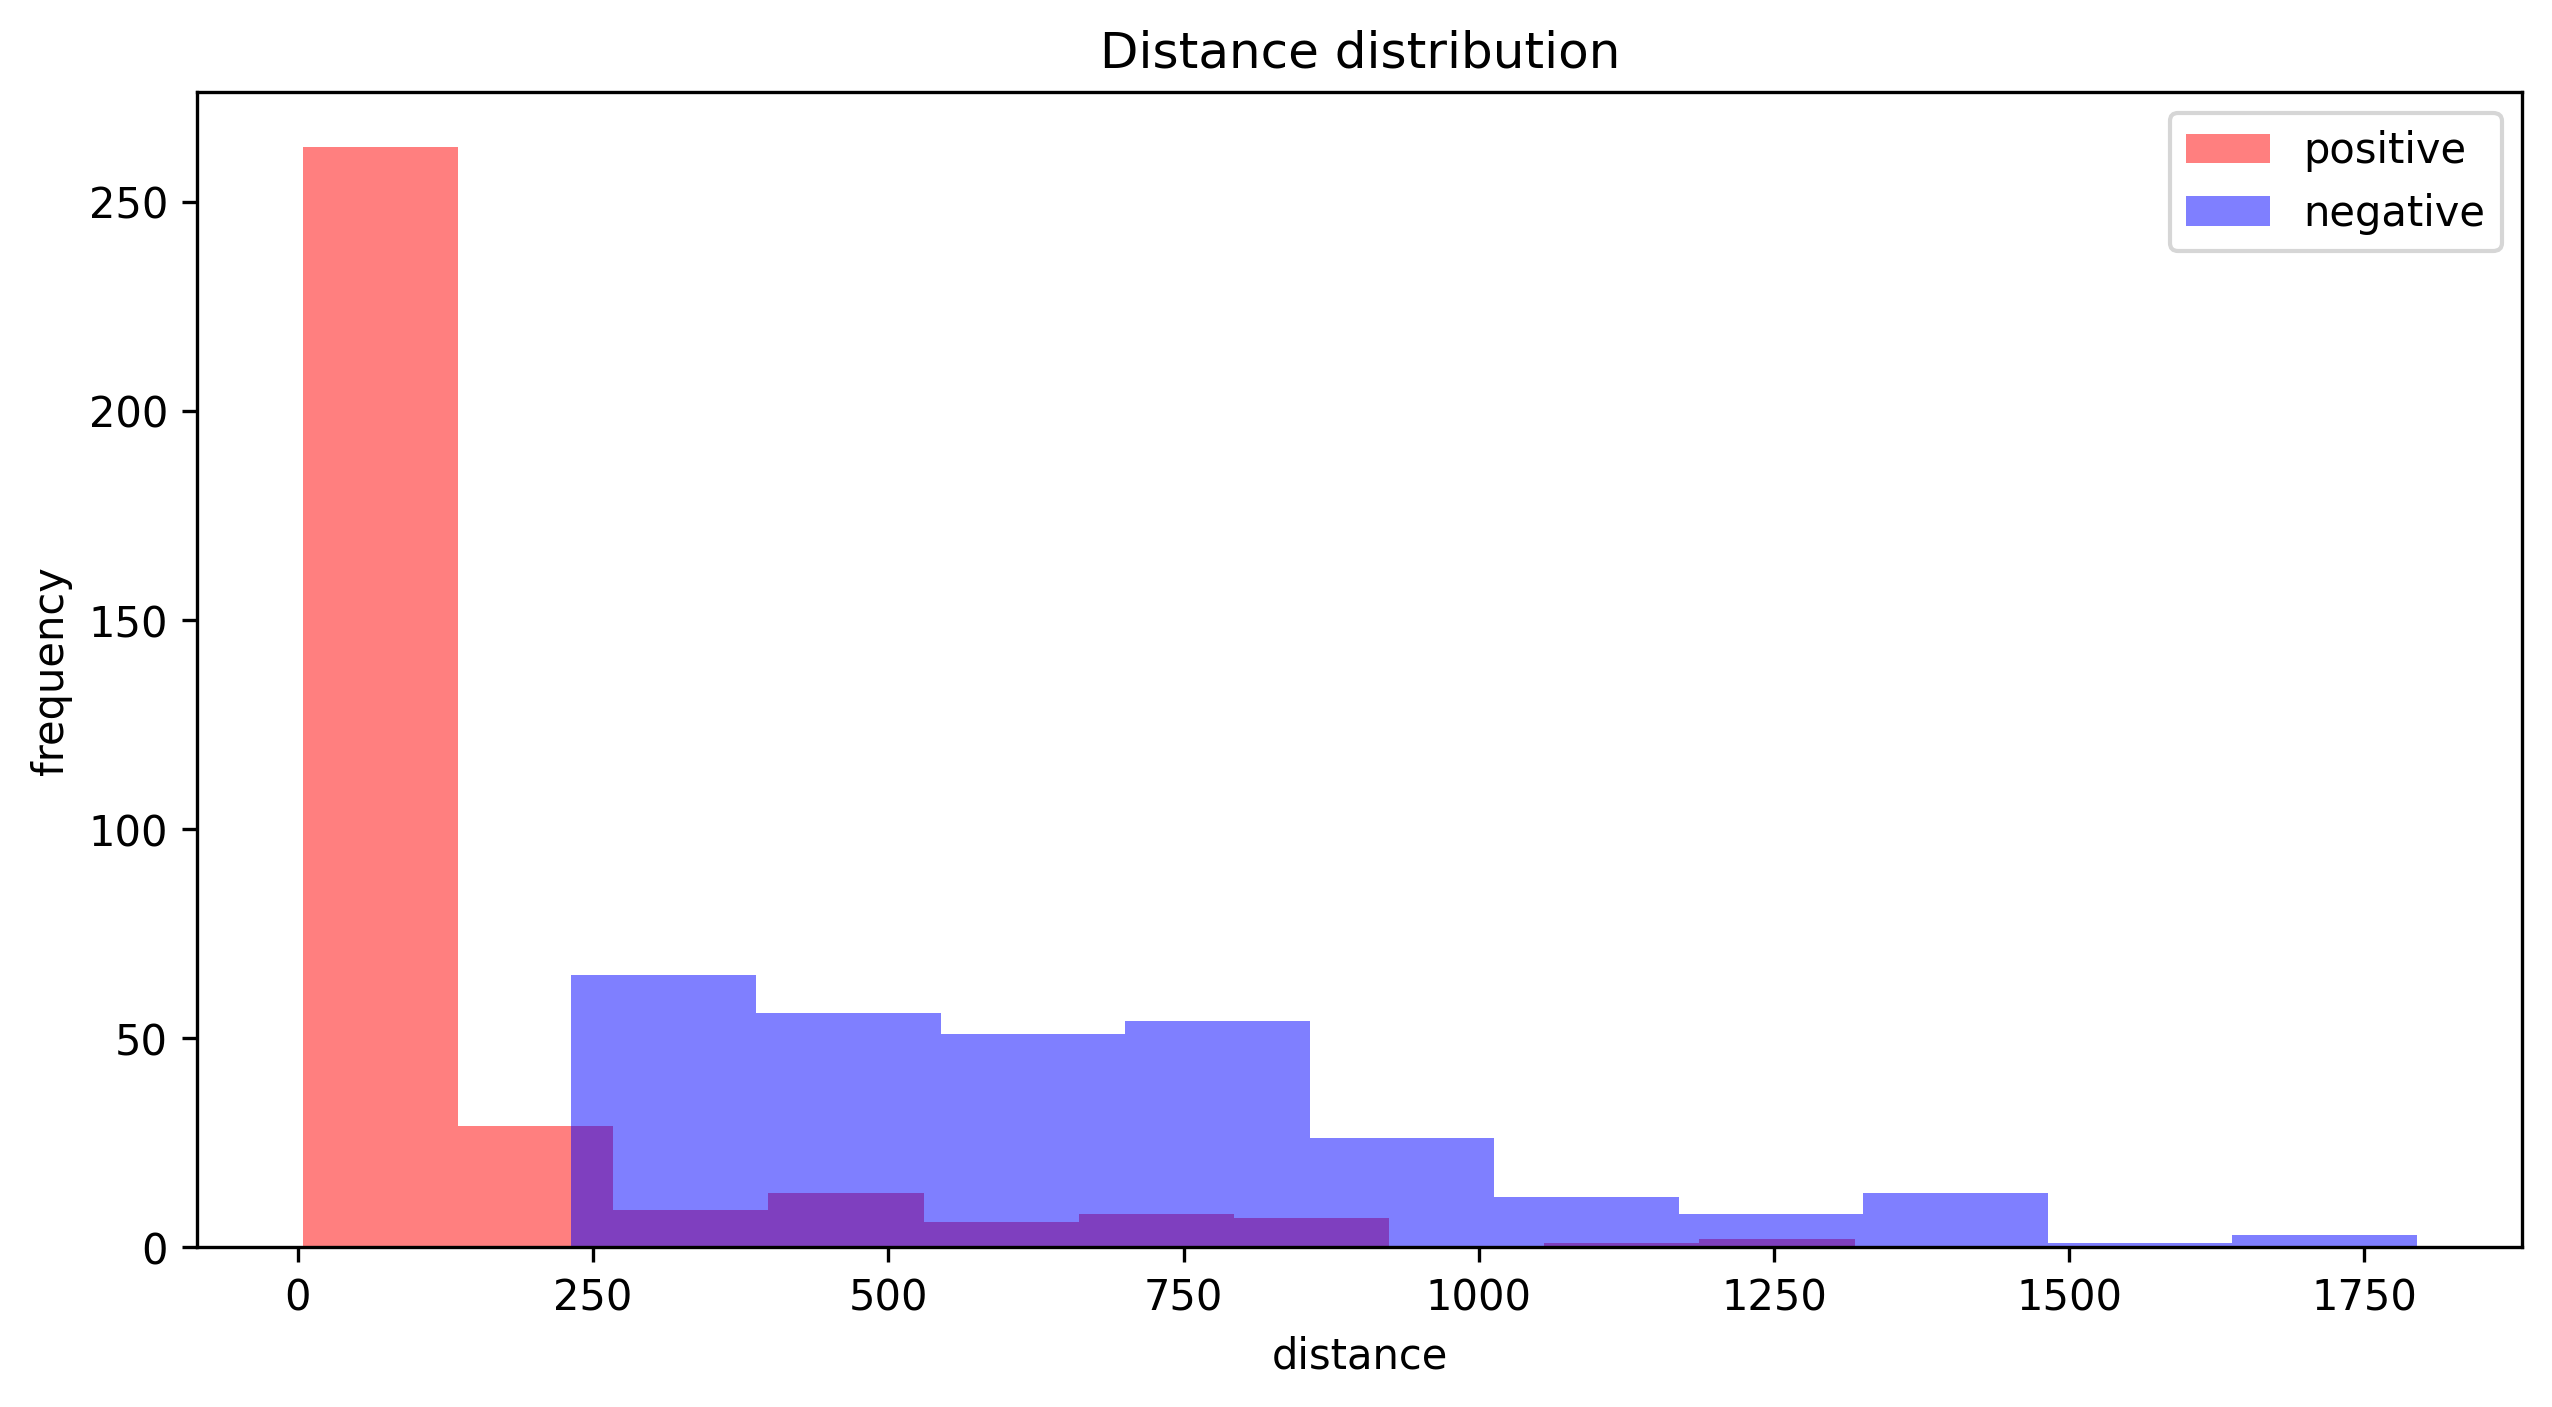

(np.float64(0.7327823023875033), np.float64(1.36837453012658))


In [32]:
# Plot of the attempt to generate testing set pairing with sequences from the redundant training set


In [64]:
# Remove redundancy from the training set
mask = train_index['id'].isin(eubacteria_pinder_ids['train'])
eubacteria_train_index = train_index[mask]
eubacteria_pinder_ids['train'] = reduce_train_redundancy(eubacteria_pinder_ids['train'], eubacteria_train_index, max_per_cluster=5)

In [65]:
# Number of elements in each split after redundancy removal
print(len(eubacteria_pinder_ids['train']),
      len(eubacteria_pinder_ids['val']),
      len(eubacteria_pinder_ids['test'])
)

6668 680 645


In [67]:
# Save IDs and phyla

print(f"Split\tClass\tNumber of instances")

for split in ["train", "val", "test"]:
    split_positives = []
    for id in eubacteria_pinder_ids[split]:
        record = {
            "pinder_id": id,
            "pinder_id_R": id.split("--")[0], 
            "pinder_id_L": id.split("--")[1], 
            f"{TAX_LEVEL}_R": eubacteria_pinder_phyla[id][0], 
            f"{TAX_LEVEL}_L": eubacteria_pinder_phyla[id][1]}
        split_positives.append(record)
    
    split_positives = pd.DataFrame.from_dict(split_positives)
    split_negatives = make_negative_pairs(split_positives, eubacteria_annotated_interactions, eubacteria_GO, tax_level=TAX_LEVEL)
    split_positives = split_positives[["pinder_id_R", "pinder_id_L", f"{TAX_LEVEL}_R", f"{TAX_LEVEL}_L"]]

    split_positives = rename_columns(split_positives, tax_level=TAX_LEVEL)
    split_negatives = rename_columns(split_negatives, to_drop="pinder_id", tax_level=TAX_LEVEL)
    
    # Balancing the set
    split_positives = split_positives.sample(n=len(split_negatives), random_state=SEED)

    # Labelling the set
    split_negatives['label'] = [0]*len(split_negatives)
    split_positives['label'] = [1]*len(split_positives)
    
    # Summary of the split
    print(f"{split}\t0\t{len(split_negatives)}\n{split}\t1\t{len(split_positives)}")

    # Merging the classes
    split_all = pd.concat([split_positives, split_negatives])
    
    # Shuffling
    split_all = split_all.sample(frac=1, random_state=SEED).reset_index(drop=True)
    
    # Saving
    split_all.to_csv(f"{SPLITS_DIR}/{split}.txt", sep="\t", index=False)
    

Split	Class	Number of instances
train	0	4617
train	1	4617
val	0	344
val	1	344
test	0	332
test	1	332


In [68]:
for split in ["train", "val", "test"]: make_split_fasta(split)

In [69]:
!cat $SPLITS_DIR/train.fasta $SPLITS_DIR/val.fasta $SPLITS_DIR/test.fasta > $SPLITS_DIR/sequences.fasta